# Dermatological Image Classification with CNNs

## Introduction

This project aims to develop an automatic classification system for dermatological images using deep learning techniques. The dataset used is HAM10000 (Human Against Machine with 10,000 training images), a collection of dermatoscopic images that represents a standard benchmark in the field of automatic skin lesion classification.

The main goal is to implement and compare different convolutional neural network architectures for the classification of seven types of skin lesions, with particular attention to class imbalance issues and the optimization of clinically relevant metrics.

## 1. 1. Data Acquisition and Preparation

In [1]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import kagglehub
from google.colab import drive

# Configuration for visualization
plt.style.use('default')
sns.set_palette("husl")

# Connecting to Google Drive for model saving
drive.mount('/content/drive')

# Downloading the HAM10000 dataset from Kaggle
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
print(f"Dataset scaricato in: {path}")

Mounted at /content/drive
Dataset scaricato in: /kaggle/input/skin-cancer-mnist-ham10000


In [2]:
# Loading the dataset metadata
metadata_path = os.path.join(path, 'HAM10000_metadata.csv')
df = pd.read_csv(metadata_path)

print("Struttura del dataset:")
print(f"Numero totale di immagini: {len(df)}")
print(f"Numero di colonne: {len(df.columns)}")
print("\nInformazioni dettagliate:")
df.info()

Struttura del dataset:
Numero totale di immagini: 10015
Numero di colonne: 7

Informazioni dettagliate:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


## 2. Exploratory Data Analysis

### 2.1  Distribution of Diagnostic Classes

The dataset presents some important characteristics: while most columns are complete, the age field contains some missing values. We proceed with the analysis of the distribution of diagnostic classes, a crucial element for understanding the nature of the classification problem.

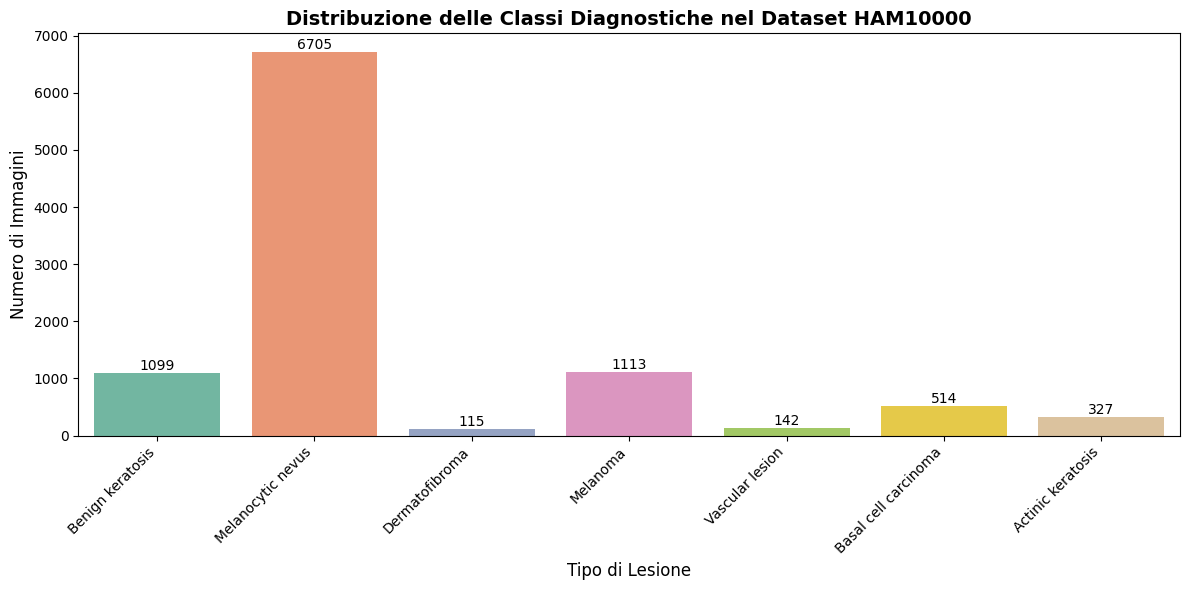

In [3]:
# Mapping of diagnostic abbreviations
label_map = {
    'nv': 'Melanocytic nevus',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'vasc': 'Vascular lesion',
    'df': 'Dermatofibroma'
}

# Creation of the column with full diagnosis names
df['diagnosis_full'] = df['dx'].map(label_map)

# Visualization of class distribution
plt.figure(figsize=(12, 6))
ax = sns.countplot(data=df, x='diagnosis_full', hue='diagnosis_full', legend=False, palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Distribuzione delle Classi Diagnostiche nel Dataset HAM10000', fontsize=14, fontweight='bold')
plt.xlabel('Tipo di Lesione', fontsize=12)
plt.ylabel('Numero di Immagini', fontsize=12)

# Adding labels with values
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width()/2., p.get_height()),
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

In [4]:
# Quantitative analysis of class distribution
class_counts = df['diagnosis_full'].value_counts()
total = len(df)
percentages = (class_counts / total * 100).round(2)

# Creation of a summary table
class_distribution = pd.DataFrame({
    'Classe': class_counts.index,
    'Numero di Campioni': class_counts.values,
    'Percentuale (%)': percentages.values
})

print("Distribuzione delle classi diagnostiche:")
print("=" * 50)
class_distribution


Distribuzione delle classi diagnostiche:


,Classe,Numero di Campioni,Percentuale (%)
0,Melanocytic nevus,6705,66.95
1,Melanoma,1113,11.11
2,Benign keratosis,1099,10.97
3,Basal cell carcinoma,514,5.13
4,Actinic keratosis,327,3.27
5,Vascular lesion,142,1.42
6,Dermatofibroma,115,1.15


### Class Imbalance

As shown in the graph, there is a significant imbalance among the dataset classes. In particular, the nv (melanocytic nevus) class is by far the most common, representing about 67% of the images.

This imbalance can affect model evaluation. For example, a classifier that always predicts the "nv" class for every image would still achieve 67% accuracy, even though it fails to distinguish any of the other classes.

For this reason, **accuracy alone is not sufficient** to properly evaluate a model.It's important to also consider other metrics, such as:
- **Recall**  (sensitivity), especially for underrepresented classes;
- **Macro-average F1 score**,  which provides a balanced view of performance across all classes.

### Considerations on the Type of Classification

When working with the **HAM10000** dataset, it is important to consider the real-world use of the model. Not all classes have the same clinical relevance:
- Some, like nevi, are benign and very common
- Others, like **melanoma**, can be dangerous or even fatal if not diagnosed in time

Depending on the objective, two approaches can be followed:
1. **7-class classification**  
   Aim to distinguish each lesion type as precisely as possible

2. **Binary classification**  
   Group lesions into two categories:
   - High-risk lesions (melanoma, basal cell carcinoma, actinic keratoses)
   - Low-risk lesions (nevi and other benign lesions)
   This approach can be useful in a medical screening scenario, where it is crucial **not to overlook serious cases**.

### Importance of the Right Metrics

In both cases, it is crucial that the model **does not produce false negatives** for high-risk classes such as melanoma. Such an error could delay diagnosis and put the patient's health at risk.

For this reason:
- **Accuracy** alone is not sufficient
- It is more useful to use metrics like **recall** for high-risk classes
- Or balanced metrics such as the **macro-average F1 score**


### In sintesi

In medical image classification, it's not enough to simply predict the most frequent class: it's much more important **not to make mistakes on critical classes**, where an error can have serious consequences.



In [5]:
# Excluding 'unknown' values in the sex attribute
df = df[df['sex'].isin(['male', 'female'])]

# Creating a table with the number of images for each diagnosis by sex
conteggi = df.groupby(['sex', 'diagnosis_full']).size().unstack(fill_value=0)

# Calculating row-wise percentages (which is to say within each sex)
percentuali = conteggi.div(conteggi.sum(axis=1), axis=0) * 100

# Displaying the table
print("Percentuali delle diagnosi rispetto al sesso:")
display(percentuali.round(2))

Percentuali delle diagnosi rispetto al sesso:


diagnosis_full,Actinic keratosis,Basal cell carcinoma,Benign keratosis,Dermatofibroma,Melanocytic nevus,Melanoma,Vascular lesion
sex,,,,,,,
female,2.33,4.33,10.17,1.14,71.11,9.31,1.60
male,4.09,5.86,11.58,1.17,63.28,12.75,1.28


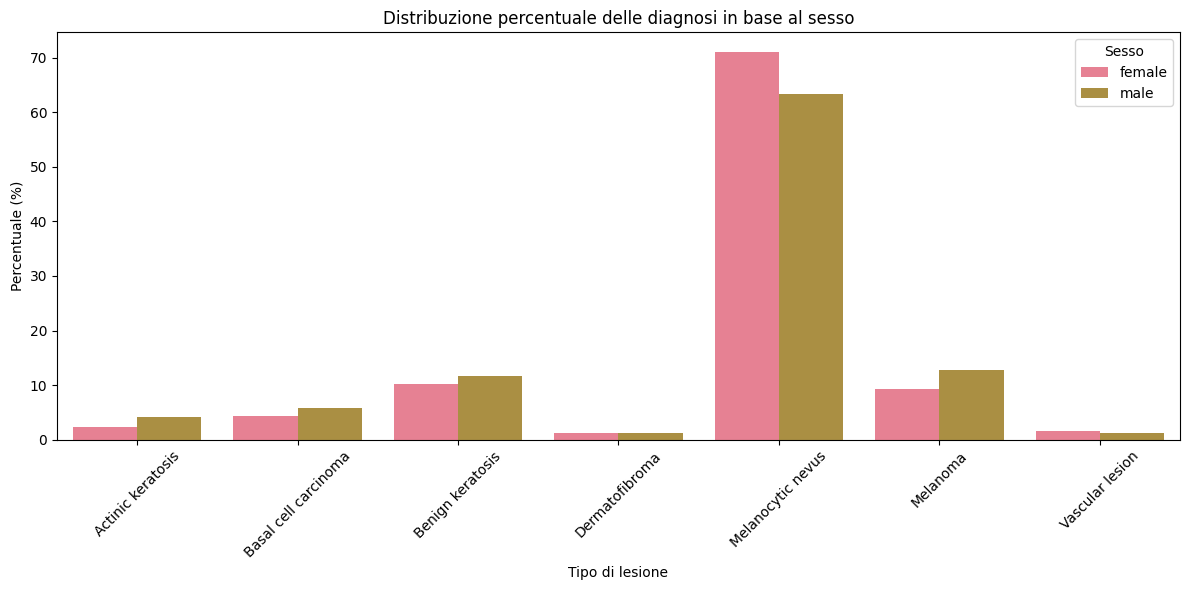

In [6]:
# Converting the table to long format for use with Seaborn
dati_grafico = percentuali.reset_index().melt(id_vars='sex', var_name='diagnosi', value_name='percentuale')

# Creating the plot
plt.figure(figsize=(12, 6))
sns.barplot(data=dati_grafico, x='diagnosi', y='percentuale', hue='sex')
plt.title('Distribuzione percentuale delle diagnosi in base al sesso')
plt.ylabel('Percentuale (%)')
plt.xlabel('Tipo di lesione')
plt.xticks(rotation=45)
plt.legend(title='Sesso')
plt.tight_layout()
plt.show()

I calculated the percentage distribution of diagnoses separately for males and females in order to see if there are any differences. The table shows the percentages for each sex, and the plot visually compares the data side by side. Some diagnoses appear to be more frequent in one sex than the other, but overall the differences are limited. It may be worth assessing whether these differences are statistically significant.

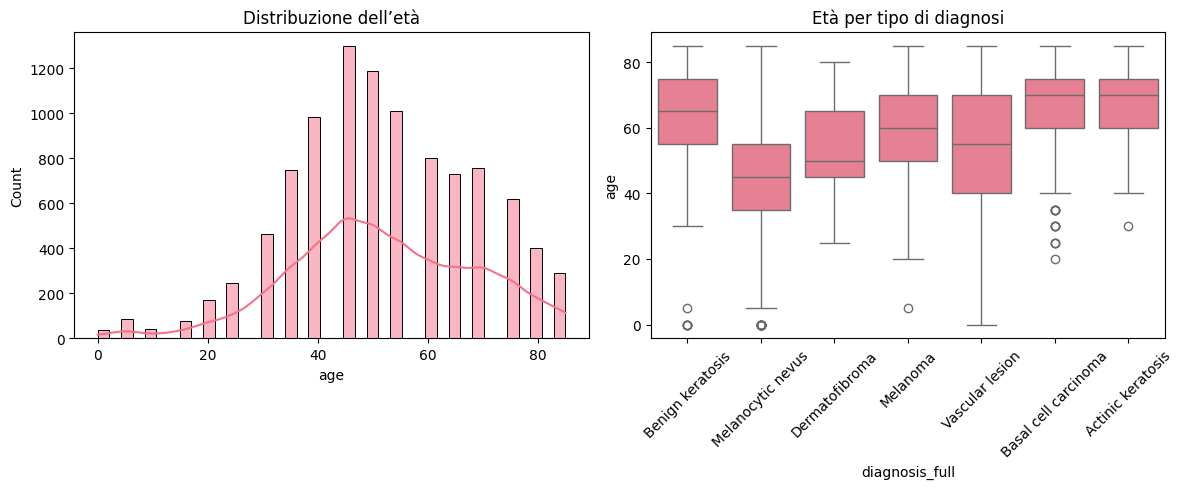

In [7]:
# Histogram and boxplot of age
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
sns.histplot(df['age'].dropna(), bins=40, kde=True)
plt.title('Distribuzione dell’età')

plt.subplot(1,2,2)
sns.boxplot(data=df, x='diagnosis_full', y='age')
plt.xticks(rotation=45)
plt.title('Età per tipo di diagnosi')
plt.tight_layout()
plt.show()


Ages vary depending on the type of lesion. Benign lesions are more evenly distributed, while lesions such as actinic keratosis and basal cell carcinoma are more common in older patients, which makes perfect medical sense. Melanoma shows some variability but still tends to appear in adulthood. This information can be useful when considering whether to include age as a predictive variable in the model.

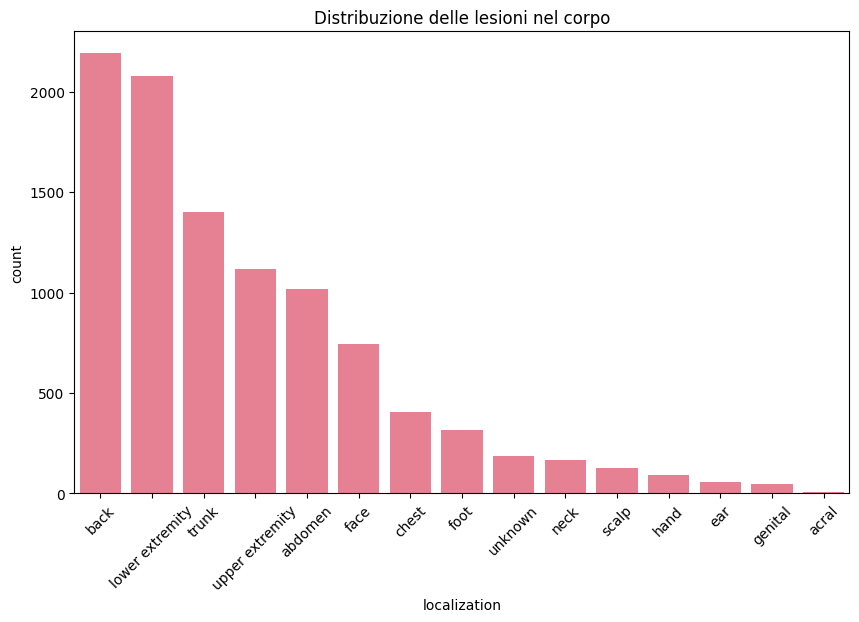

In [8]:
plt.figure(figsize=(10,6))
sns.countplot(data=df, x='localization',
              order=df['localization'].value_counts().index)
plt.xticks(rotation=45)
plt.title('Distribuzione delle lesioni nel corpo')
plt.show()


The dataset shows a non-uniform distribution of body locations: most lesions are concentrated on areas such as the back, lower limbs, and trunk. Some regions, such as the scalp, hands, ears, and genitals, are represented by only a very small number of images.

This information can be useful during analysis and modeling: a model may, in fact, be more accurate on lesions located in well-represented areas and less reliable on those that are rarer.

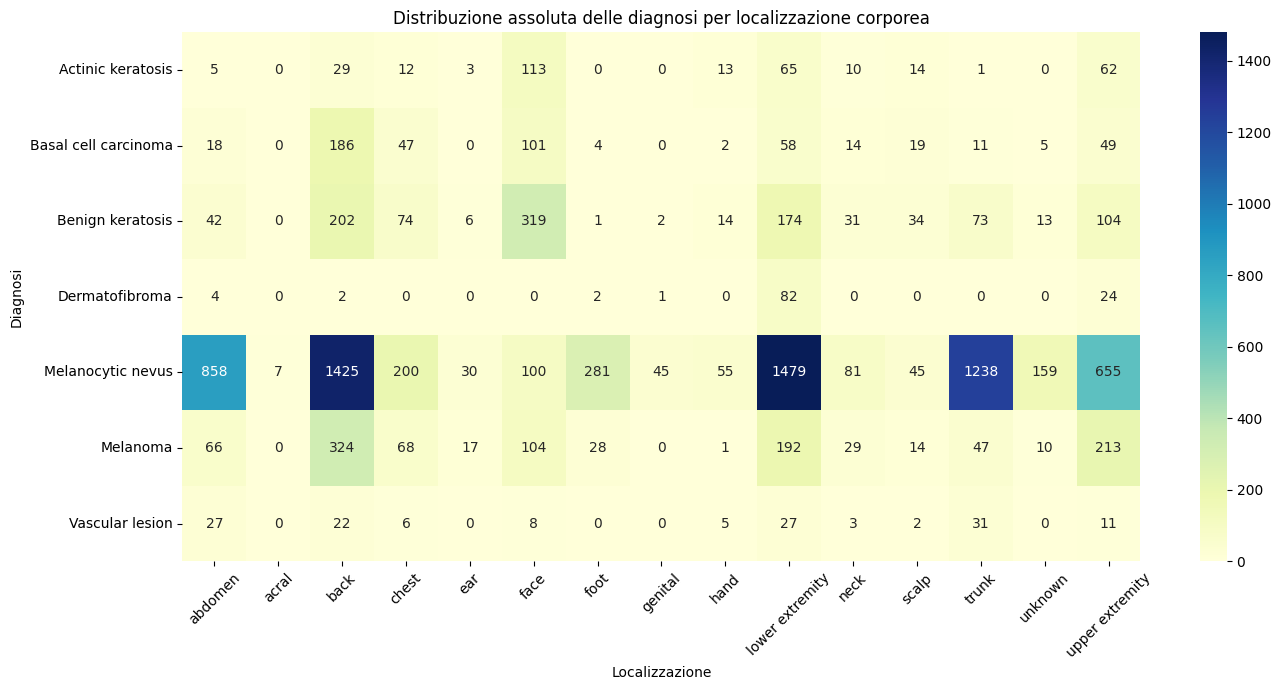

In [9]:
# Standard heatmap with absolute values
ct = pd.crosstab(df['diagnosis_full'], df['localization'])

plt.figure(figsize=(14, 7))
sns.heatmap(ct, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Distribuzione assoluta delle diagnosi per localizzazione corporea')
plt.xlabel('Localizzazione')
plt.ylabel('Diagnosi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


This first heatmap shows the number of images for each combination of diagnosis and body location. It is useful for getting a general sense of the distribution, but it can be misleading: the Melanocytic nevus class dominates the dataset and tends to overshadow all the others. For this reason, it is not easy to compare the proportions of different diagnoses within a single anatomical area.

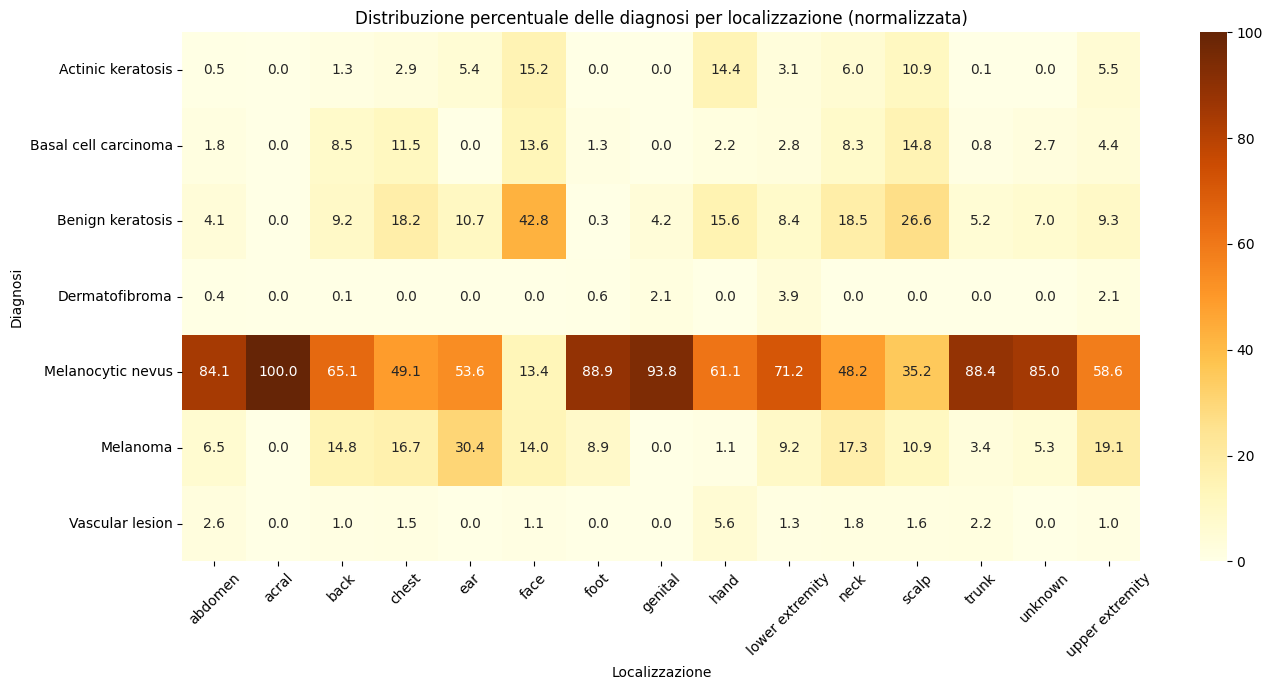

In [10]:
# Heatmap with location-normalized percentages
normalized = ct.div(ct.sum(axis=0), axis=1) * 100

plt.figure(figsize=(14, 7))
sns.heatmap(normalized, annot=True, fmt='.1f', cmap='YlOrBr')
plt.title('Distribuzione percentuale delle diagnosi per localizzazione (normalizzata)')
plt.xlabel('Localizzazione')
plt.ylabel('Diagnosi')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Analysis of normalized anatomical distribution

In order to obtain a more useful view of lesion distribution, we created a second heatmap normalized **by column**. In practice, each column represents a body area, and the values indicate **the percentage** of lesions in that area that belong to each diagnostic class.

In this way, we can see **which types of lesions are most common in each body area**, regardless of the total number of images available for each region.

Some interesting examples:

- **Face and scalp**: here, the most common lesions **are not nevi**, but **actinic keratoses** and **basal cell carcinomas**.
- **Genital region and sole of the foot**: in these areas, over 90% of the lesions are **melanocytic nevi**, although the absolute number of cases is low.
- **Melanoma**: it has a more homogeneous distribution, but with higher peaks on the **chest, back**, and **lower limbs**.

This visualization can be very useful for:
- Identifying **clinical patterns** related to lesion location
- Understanding whether it is beneficial to include **anatomical location** as an input variable in the classification model


For illustrative purposes only, I show an example image for each type of skin lesion.

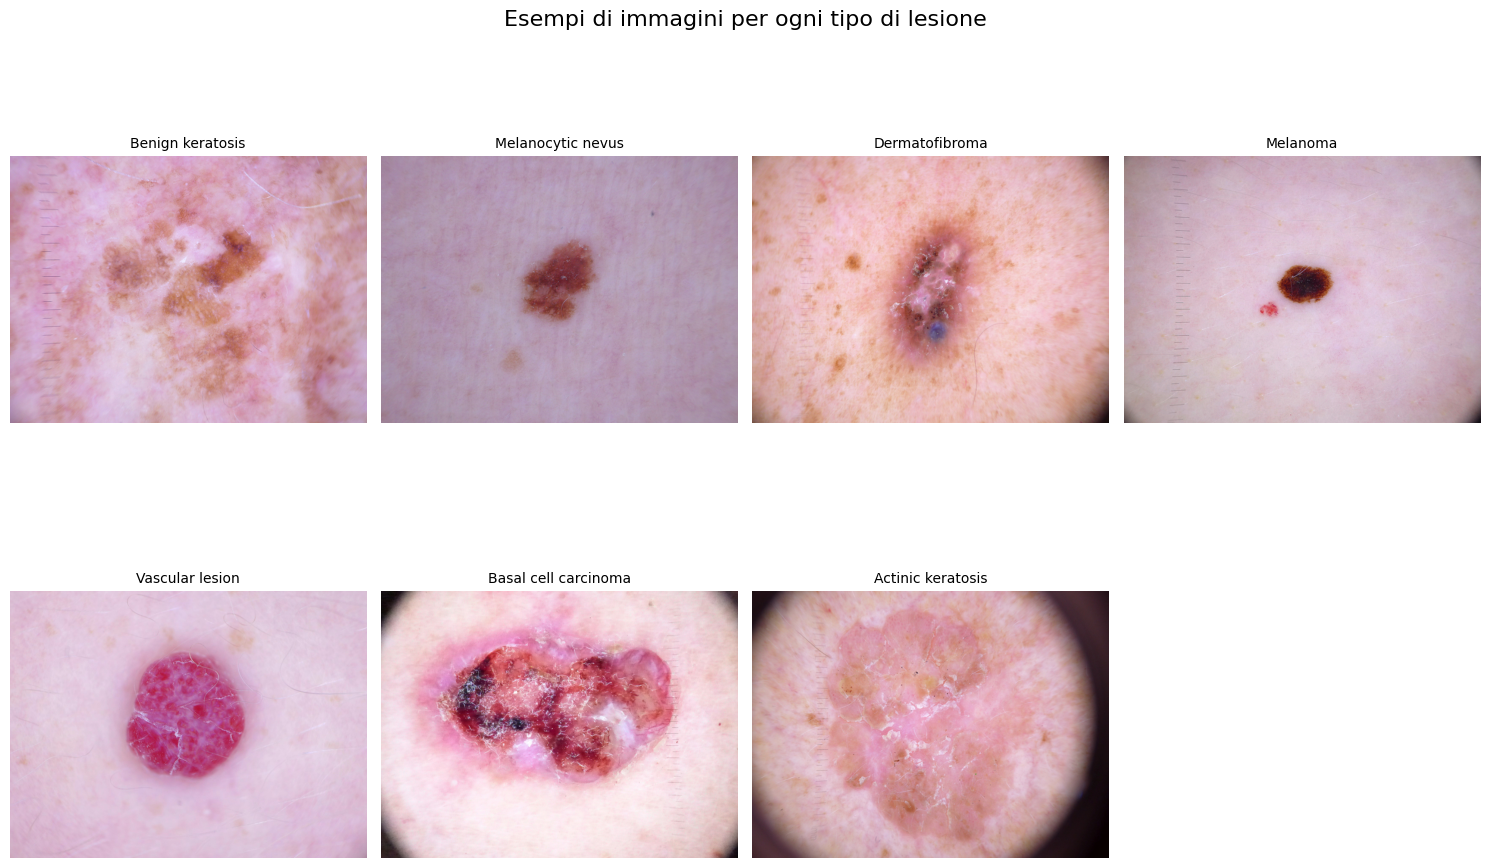

In [11]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Downloading the dataset
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")

# Image folders
cartella1 = os.path.join(path, "HAM10000_images_part_1")
cartella2 = os.path.join(path, "HAM10000_images_part_2")

# Loading the metadata
df = pd.read_csv(os.path.join(path, "HAM10000_metadata.csv"))

# Mapping to make diagnosis names readable
label_map = {
    'nv': 'Melanocytic nevus',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratosis',
    'vasc': 'Vascular lesion',
    'df': 'Dermatofibroma'
}
df['diagnosi'] = df['dx'].map(label_map)

# Function to search for the image
def trova_immagine(image_id):
    file = image_id + ".jpg"
    if os.path.exists(os.path.join(cartella1, file)):
        return os.path.join(cartella1, file)
    elif os.path.exists(os.path.join(cartella2, file)):
        return os.path.join(cartella2, file)
    else:
        return None

# Creating a list with a single image for each diagnosis
diagnosi_uniche = df['diagnosi'].unique()
campioni = []

for diagnosi in diagnosi_uniche:
    riga = df[df['diagnosi'] == diagnosi].iloc[0]
    campioni.append(riga)

# Displaying the images
plt.figure(figsize=(15, 10))
for i, riga in enumerate(campioni):
    img_path = trova_immagine(riga['image_id'])
    if img_path:
        img = mpimg.imread(img_path)
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(riga['diagnosi'], fontsize=10)
        plt.axis('off')

plt.suptitle("Esempi di immagini per ogni tipo di lesione", fontsize=16)
plt.tight_layout()
plt.show()


At this point, we prepare the dataset to be used in a CNN. The images in the dataset are divided into two separate folders, so we use the function defined in the previous block which, given each image ID, locates the correct file in one of the two folders.

Next, we add the full file path of each image to the dataframe and remove any rows that do not have an associated image (to avoid errors during training).

We then convert the diagnoses (which are written as text labels, such as “melanoma” or “nevus”) into numerical values using automatic encoding, which is necessary for training the model.

Finally, we split the dataset into two subsets (while preserving class proportions):
- one for training the model (80% of the data),
- one for testing (20% of the data).

This gives us a clean, labeled dataset ready to be used in the next phase.



In [12]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Image paths
cartella1 = os.path.join(path, "HAM10000_images_part_1")
cartella2 = os.path.join(path, "HAM10000_images_part_2")

# Applying the function to the dataframe
df['image_path'] = df['image_id'].apply(trova_immagine)

# Removing any rows without an image
df = df[df['image_path'].notnull()]

# Numerical encoding of the 'diagnosis' column
le = LabelEncoder()
df['label'] = le.fit_transform(df['diagnosi'])

# Splitting the dataset into train and test (80/20). Stratify is used to preserve class proportions.
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Showing an example
print(train_df[['diagnosi', 'label']].head())


               diagnosi  label
5783  Melanocytic nevus      4
7864  Melanocytic nevus      4
328    Benign keratosis      2
8566  Melanocytic nevus      4
1401           Melanoma      5


### Image preparation

In this phase, we focused on preparing the images to be fed into the model, without applying any transformations or modifications to the original data..

We used Keras's `ImageDataGenerator` class solely to normalize pixel values, using the parameter `rescale=1./255`. This scales all pixel values to the [0, 1] range, which helps ensure numerically stable training for the neural network.

No data augmentation was applied at this stage: no rotations, zooms, or horizontal flips. These operations may be introduced at a later stage.

To load the images, two generators were created using  `flow_from_dataframe()`:
- One for the training set, which reads the images in batches and associates them with their labels;
- One for the test set, used for the final evaluation of the model.

The main parameters are:

- `target_size = (224, 224)`  
 Images are resized to 224x224 pixels, a size compatible with several pre-trained models.
 The original images were 600x450, so some visual information may be lost in the resizing process.

- `batch_size = 32`  
  This is the number of images loaded and processed simultaneously by the model. It’s a standard value that offers a good balance between performance and memory usage.

- `class_mode = 'categorical'`  
  This parameter is suitable for multi-class classification problems with a softmax output.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Normalization only for training and test sets
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Parameters
img_size = (224, 224)
batch_size = 32

# Data generator for training
train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_path',
    y_col='diagnosi',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True
)

# Data generator for testing
test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='diagnosi',
    target_size=img_size,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


### Initial model architecture

For the initial training, a simple convolutional neural network (CNN) was used, consisting of **three convolutional blocks followed by pooling**, and a final classifier based on dense layers.

The structure follows a classic design, similar to models like **LeNet** or **VGG**, with a **progressive increase in the number of filters** in the convolutional blocks: **32 → 64 → 128**  
This scheme allows the model to first capture simple patterns, such as edges or textures, and then more complex and abstract features.

This choice is based on several considerations:

- The dataset contains **color images** with well-defined visual content (skin lesions), making the use of convolutions particularly suitable.
- Similar architectures **have already been used in many studies** for medical image classification tasks.
- The goal was to design a network **deep enough to generalize well**, but **not too heavy**, in order to keep training times reasonable..


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import pandas as pd

# Saving paths
model_path = '/content/drive/MyDrive/model_cnn_simple.keras'
history_path = '/content/drive/MyDrive/history_cnn_simple.csv'

# Number of classes
num_classes = len(train_generator.class_indices)

# Check if saved model exists
if os.path.exists(model_path):
    print("Modello già esistente. Caricamento in corso...")
    model = load_model(model_path, compile=False)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Modello caricato.")
else:
    print("Nessun modello salvato trovato. Creo un nuovo modello CNN...")

    # Simple CNN architecture
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    print("Avvio addestramento...")
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator
    )

    # Save the model
    model.save(model_path)
    print(f"Modello salvato in: {model_path}")

    # Save the training history
    pd.DataFrame(history.history).to_csv(history_path, index=False)
    print(f"Storico addestramento salvato in: {history_path}")


Modello già esistente. Caricamento in corso...
Modello caricato.


At this point, we evaluate the training progress by comparing the accuracy and loss on both the training and validation sets.

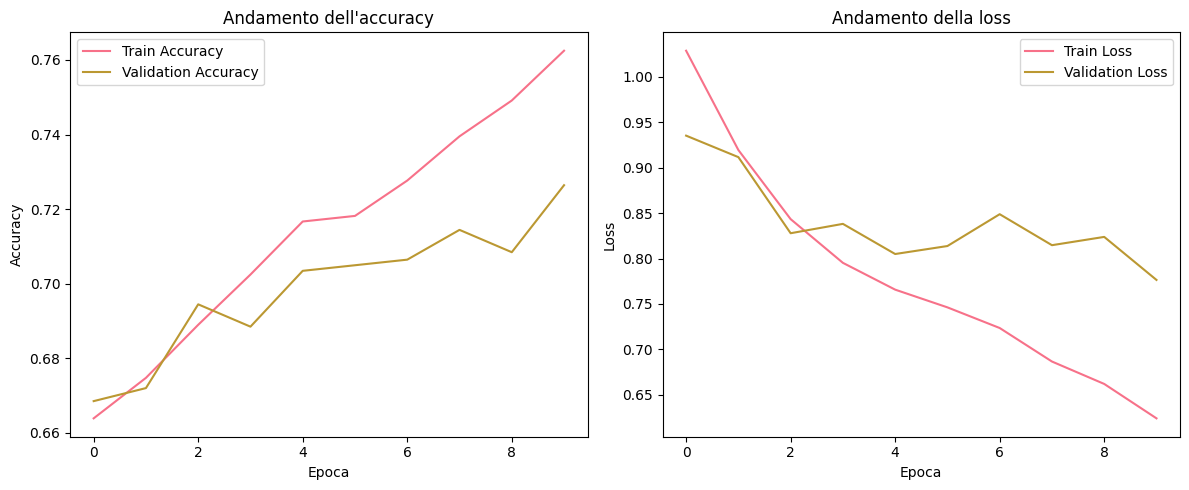

In [ ]:
import matplotlib.pyplot as plt
history_df = pd.read_csv(history_path)
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Andamento dell\'accuracy')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Andamento della loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Training Analysis

Looking at the plots, a few important things can be observed::

**Accuracy:**
- The accuracy on the training set increases steadily, reaching up to 76% after 9 epochs.
- The accuracy on the validation set is less stable and fluctuates significantly from one epoch to another.
- The growing gap between training and validation accuracy suggests the beginning of overfitting.
- Despite the fluctuations, the validation accuracy remains between 72% and 73%, indicating that the model is still able to generalize fairly well..

**Loss:**
- The loss on the training set decreases steadily, from 1.02 to 0.62, indicating that the model is learning.
- The loss on the validation set decreases at first, then stabilizes between 0.80 and 0.85.
- Here too, the difference between the two curves confirms the presence of overfitting.

**Conclusions:** The model shows good learning but tends to overfit the training data.

In [ ]:
# Evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy sul test set: {test_accuracy:.2%}")
print(f"Loss sul test set: {test_loss:.4f}")



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7294 - loss: 0.7845
Accuracy sul test set: 72.64%
Loss sul test set: 0.7764


To evaluate the model's performance, in addition to simple accuracy, precision, recall, and F1-score (macro average) were also calculated. This approach is useful in contexts like HAM10000, where some classes are underrepresented.

The confusion matrix and the classification report help identify which classes the model struggles to recognize and clearly highlight the limitations related to the dataset imbalance.

63/63 ━━━━━━━━━━━━━━━━━━━━ 80s 1s/step
Accuracy: 72.64%
Precision (macro): 48.23%
Recall (macro): 37.62%
F1 Score (macro): 40.15%


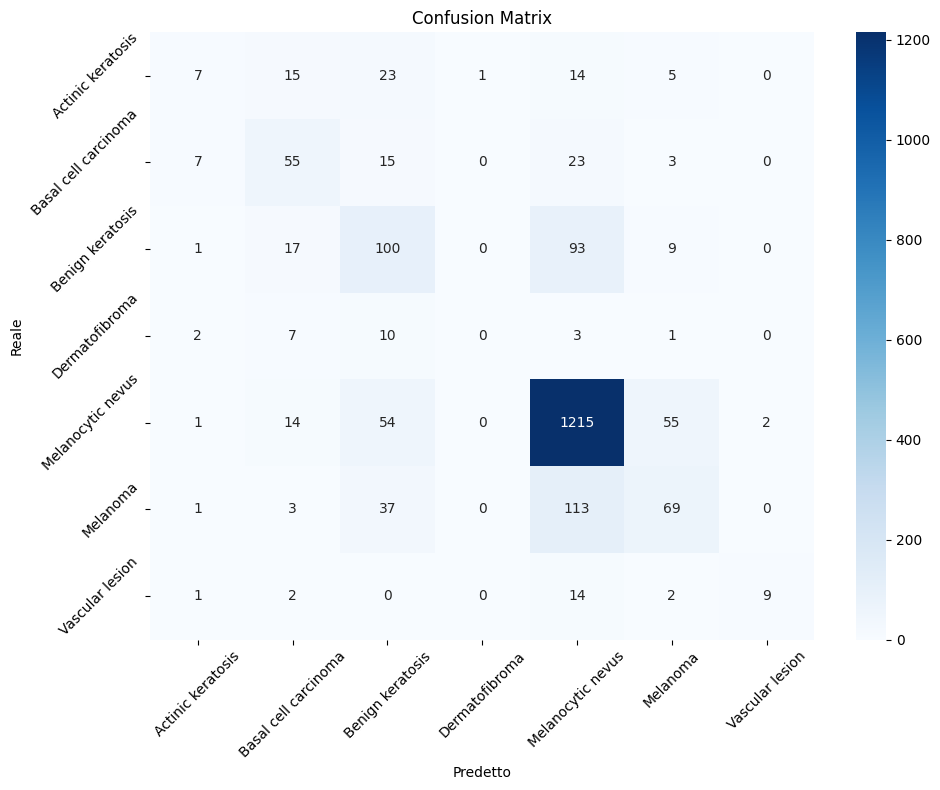

Classification Report:

                      precision    recall  f1-score   support

   Actinic keratosis       0.35      0.11      0.16        65
Basal cell carcinoma       0.49      0.53      0.51       103
    Benign keratosis       0.42      0.45      0.44       220
      Dermatofibroma       0.00      0.00      0.00        23
   Melanocytic nevus       0.82      0.91      0.86      1341
            Melanoma       0.48      0.31      0.38       223
     Vascular lesion       0.82      0.32      0.46        28

            accuracy                           0.73      2003
           macro avg       0.48      0.38      0.40      2003
        weighted avg       0.70      0.73      0.71      2003



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # predicted classes
y_true = test_generator.classes           # real classes

# Classes (in numerical order)
class_labels = list(test_generator.class_indices.keys())

# Simple accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, recall, F1 (macro = equally weighted average across all classes)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {acc:.2%}")
print(f"Precision (macro): {precision:.2%}")
print(f"Recall (macro): {recall:.2%}")
print(f"F1 Score (macro): {f1:.2%}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Full report by class
report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
print("Classification Report:\n")
print(report)


### Evaluation of the baseline model

The baseline model, trained on the original dataset **without transformations or balancing**, achieves an **overall accuracy of 73%** on the test set.

However, the class-by-class analysis shows that this average value **hides significant imbalances** in the model's performance.

- The **Melanocytic nevus** class, which makes up the majority of the dataset, also has the best performance: **Precision: 82%**, **recall: 91%**, **F1-score: 86%**. This indicates a strong tendency of the model to favor the most frequent classes.

- Clinically important but underrepresented classes show much weaker results:
  - **Melanoma**: precision 48%, recall 31%, F1-score 38%
  - **Actinic keratosis**: recall only 11%, F1-score 16%
  - **Dermatofibroma**: recall is 0, the model never correctly classifies this class

- Other classes, such as **Vascular lesion**, also show imbalanced behavior: high precision (82%) but low recall (32%).

Overall, the model achieves:
- **Macro-average F1-score**: 0.40
- **Weighted-average F1-score**: 0.71

These numbers confirm that the model struggles to generalize to the underrepresented classes, which are systematically underestimated.

In the medical field, this is particularly critical: **failing to recognize a malignant lesion can have serious consequences**. For this reason, it is essential to evaluate the model using more balanced metrics, such as **recall and F1-score for high-risk classes**, rather than relying solely on overall accuracy.


### Handling Imbalance and Data Augmentation

To address the class imbalance problem in the **HAM10000** dataset, a **partial balancing** strategy was adopted, which is more realistic than full equalization.
- Classes with more than 4000 images were undersampled to 4000 examples.
- Classes with fewer than 1000 images were augmented through oversampling to at least 1000 examples.
- Classes with an intermediate number of samples were left unchanged.

This approach helps reduce imbalance while maintaining good data variety, avoiding excessive artificial duplication.

- **Oversampling** was performed using Scikit-learn’s `resample`method, which randomly duplicates images from the minority classes.
- **Undersampling** was carried out by randomly reducing the size of the larger classes.


After balancing the training set, a data augmentation process was applied using Keras’s`ImageDataGenerator`.  
During training, images are transformed with slight random variations (rotations, shifts, zooms, horizontal flips, etc.) with the goal to:
- Simulate new realistic samples;
- Increase variety in the data seen by the model;
- Reduce the risk of overfitting.

The **test set**, on the other hand, is only **normalized** (scaling pixel values between 0 and 1), with no transformations applied, to ensure an unbiased evaluation of the model’s performance.

Finally, the generators were created:
- `train_generator`, which loads batches of balanced and augmented images during training;
- `test_generator`, which loads the normalized test set for final evaluation.

These generators enable **efficient loading of data from disk** throughout all phases of the process.


In [ ]:
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Settings
random_state = 9
min_samples = 1000
max_samples = 4000

# 1. Partial balancing
balanced_dfs = []

for diagnosi, gruppo in train_df.groupby('diagnosi'):
    count = len(gruppo)
    if count > max_samples:
        # Sottocampiona
        gruppo_mod = gruppo.sample(n=max_samples, random_state=random_state)
    elif count < min_samples:
        # Oversampling
        gruppo_mod = resample(gruppo,
                              replace=True,
                              n_samples=min_samples,
                              random_state=random_state)
    else:
        # Leave unchanged
        gruppo_mod = gruppo
    balanced_dfs.append(gruppo_mod)

# 2. Final balanced DataFrame
train_df_balanced = pd.concat(balanced_dfs).sample(frac=1, random_state=random_state).reset_index(drop=True)

# 3. Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1,
    shear_range=0.1
)

# 4. Normalization only for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# 5. Image generators
train_generator = train_datagen.flow_from_dataframe(
    train_df_balanced,
    x_col='image_path',
    y_col='diagnosi',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_path',
    y_col='diagnosi',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

# 6. Check distribution
print("Distribuzione del dataset bilanciato (training):")
print(train_df_balanced['diagnosi'].value_counts())


Found 10000 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.
Distribuzione del dataset bilanciato (training):
diagnosi
Melanocytic nevus       4000
Vascular lesion         1000
Dermatofibroma          1000
Actinic keratosis       1000
Benign keratosis        1000
Melanoma                1000
Basal cell carcinoma    1000
Name: count, dtype: int64


### Training the CNN model with the balanced dataset

The model was retrained using a **balanced dataset**, obtained through **oversampling of the underrepresented classes**. **Data augmentation** was applied to the duplicated images to increase variety and reduce the risk of overfitting.
During training, an **automatic saving** mechanism (`ModelCheckpoint`) was used to retain the model with the **best performance on the validation set**. This helps avoid using versions of the model that may have started to overfit the training data.


In [ ]:

import os
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

checkpoint_path = '/content/drive/MyDrive/model_balanced.h5'
history_path = '/content/drive/MyDrive/history_balanced.csv'

if os.path.exists(checkpoint_path):
    print("Modello già addestrato trovato. Caricamento in corso...")
    model = load_model(checkpoint_path)
    history = pd.read_csv(history_path)
else:
    print("Nessun modello salvato trovato. Creazione e addestramento di un nuovo modello...")

    num_classes = len(train_generator.class_indices)

    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.3),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(
        optimizer=Adam(1e-5),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    model.summary()

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[checkpoint]
    )

    if history:
        print("Salvataggio della cronologia...")
        hist_df = pd.DataFrame(history.history)
        hist_df['epoch'] = hist_df.index + 1
        hist_df.to_csv(history_path, index=False)
        print(f"Cronologia salvata in: {history_path}")


Modello già addestrato trovato. Caricamento in corso...


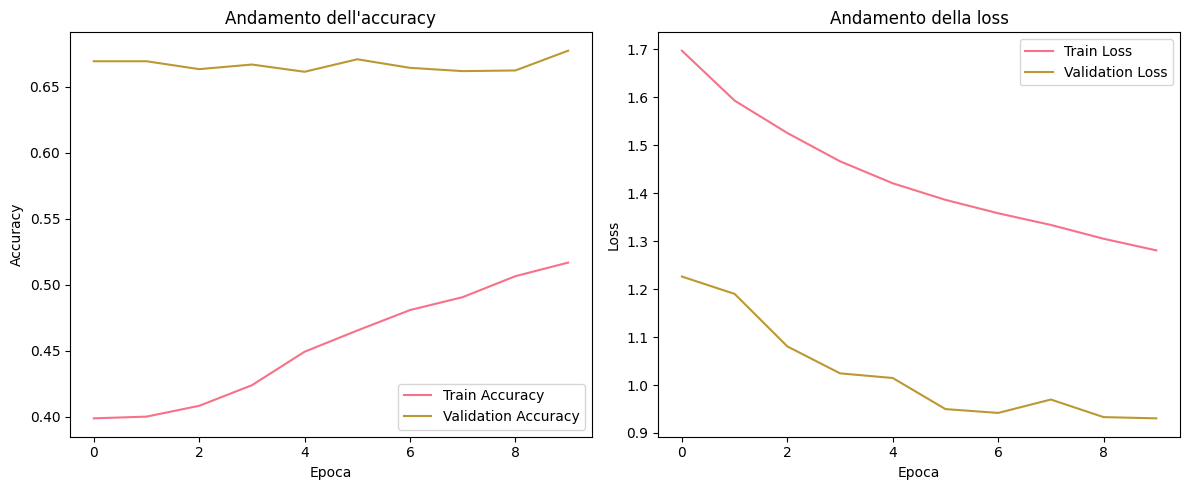

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
history_df = pd.read_csv(history_path)
# Plot accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title('Andamento dell\'accuracy')
plt.xlabel('Epoca')
plt.ylabel('Accuracy')
plt.legend()

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title('Andamento della loss')
plt.xlabel('Epoca')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


### Training analysis with balanced dataset

The plots show the trends of **accuracy** and **loss** on the training and validation sets during the first 10 epochs of training with the balanced model.

- **Training accuracy** increases steadily, indicating that the model is progressively learning from the data.
However, **validation accuracy** remains almost stable around 67–68%, suggesting that improvements on the training set **do not translate into real gains in generalization**.

- In the second plot, **training loss** decreases consistently, while **validation loss** drops more rapidly at the beginning and then levels off.
Again, a noticeable **difference between training and validation loss** can be observed, which may indicate the beginning of **overfitting**.

In summary, the model appears to be learning from the data, but its **generalization ability remains limited**, probably due to the complexity of the problem and the characteristics of the dataset. Interventions such as stronger regularization or a more advanced architecture could help.


In [ ]:
# Evaluation on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Accuracy sul test set: {test_accuracy:.2%}")
print(f"Loss sul test set: {test_loss:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.6639 - loss: 0.9359
Accuracy sul test set: 67.75%
Loss sul test set: 0.9305


63/63 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step
Accuracy: 67.75%
Precision (macro): 41.36%
Recall (macro): 39.53%
F1 Score (macro): 36.00%


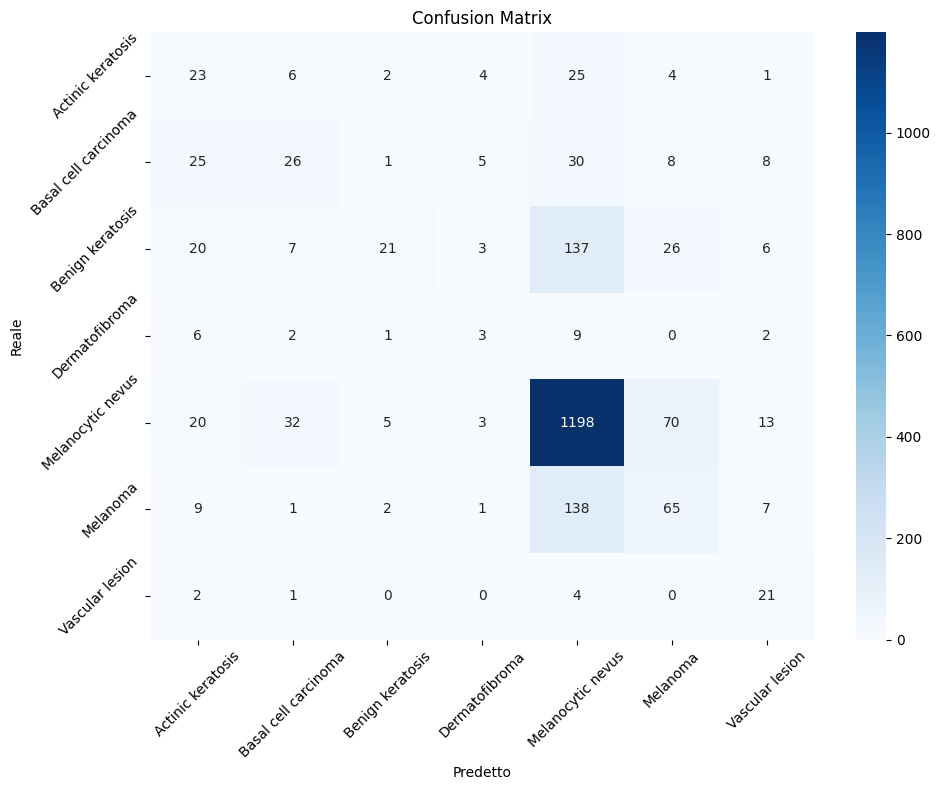

Classification Report:

                      precision    recall  f1-score   support

   Actinic keratosis       0.22      0.35      0.27        65
Basal cell carcinoma       0.35      0.25      0.29       103
    Benign keratosis       0.66      0.10      0.17       220
      Dermatofibroma       0.16      0.13      0.14        23
   Melanocytic nevus       0.78      0.89      0.83      1341
            Melanoma       0.38      0.29      0.33       223
     Vascular lesion       0.36      0.75      0.49        28

            accuracy                           0.68      2003
           macro avg       0.41      0.40      0.36      2003
        weighted avg       0.67      0.68      0.64      2003



In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions on the test set
y_pred_prob = model.predict(test_generator)
y_pred = np.argmax(y_pred_prob, axis=1)  # predicted classes
y_true = test_generator.classes           # real classes

# Classes (in numerical order)
class_labels = list(test_generator.class_indices.keys())

# Simple accuracy
acc = accuracy_score(y_true, y_pred)

# Precision, recall, F1 (macro = equally weighted average across all classes)
precision = precision_score(y_true, y_pred, average='macro', zero_division=0)
recall = recall_score(y_true, y_pred, average='macro', zero_division=0)
f1 = f1_score(y_true, y_pred, average='macro', zero_division=0)

print(f"Accuracy: {acc:.2%}")
print(f"Precision (macro): {precision:.2%}")
print(f"Recall (macro): {recall:.2%}")
print(f"F1 Score (macro): {f1:.2%}")

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Full report by class
report = classification_report(y_true, y_pred, target_names=class_labels, zero_division=0)
print("Classification Report:\n")
print(report)


### Performance improvement after balancing

After balancing the dataset and introducing **data augmentation**, the model showed an improvement in its **ability to recognize even the underrepresented classes**, compared to the previous version.

The **melanoma class**, while still challenging to classify, achieved a **recall of 29%** and an **F1-score of 33%**. Although far from ideal, these values still represent an improvement compared to the initial situation, where melanoma was often overlooked.

The **macro metrics** confirm a more balanced picture:
- **Macro-average recall**: 39.5%
- **Macro-average precision**: 41.3%
- **Macro-average F1-score**: 36.0%

Although the **overall accuracy is 67.75%**, slightly lower than in the previous version, the model shows a more balanced behavior across classes. Some examples:
- **Vascular lesion**: recall 75%, F1-score 49%
- **Actinic keratosis**: recall 35%, F1-score 27%
- **Dermatofibroma**: F1-score 14%, despite the limited amount of data

These results highlight how a model, with similar overall accuracy, can be much more useful when evaluated using metrics that account for class balance.

In medical contexts, where correctly identifying even rare cases is critical, it's better to **optimize overall performance across all categories** rather than focusing solely on general accuracy.


### MobileNetV2 Model

After the initial experiments with a simple CNN, it was decided to try a more advanced and well-established model: **MobileNetV2**.

MobileNetV2 is a convolutional neural network designed to be **lightweight and fast**, yet still capable of delivering strong performance. It is widely used in practical applications because it requires less memory and computational power compared to larger models (such as ResNet or VGG), while still maintaining good visual recognition capabilities.


#### Main choices:

- **Pre-trained MobileNetV2**: We loaded the network with **weights pre-trained on ImageNet**, a large general-purpose dataset. This allows us to leverage the model’s already learned knowledge to recognize visual patterns in the dermatological images of our dataset.
- **Feature extractor (frozen weights)**: Initially, the weights of the base network are **frozen** (`trainable = False`), so the network is used purely as a feature extractor without retraining it. This approach reduces the risk of overfitting, especially when the dataset is not very large.
- **Custom classifier**:
  - `GlobalAveragePooling2D`: reduces the output size of the CNN into a compact vector.
  - `Dropout(0.3)`: helps prevent overfitting by introducing randomness during training.
  - `Dense(num_classes, activation='softmax')`: final layer for multi-class classification, with one unit per class and softmax activation.

- **Model compilation:**:
  - **Optimizer:**: `Adam`, hosen for its efficiency and stability.
  - **Loss**: `categorical_crossentropy`, suitable for multi-class classification problems.
  - **Metrics**: `accuracy`, used to monitor performance during training..

#### Model saving and reuse management
- If a saved model already exists on Google Drive, it is automatically loaded to avoid retraining from scratch.
- Otherwise, a new MobileNetV2 model is created and trained from the beginning.


#### Callbacks used during training:

- `ModelCheckpoint`: automatically saves the model with the best performance on the validation set, ensuring the most effective version is not lost.
- `EarlyStopping`: stops training if the validation loss does not improve for 3 consecutive epochs, avoiding unnecessary training time.
- `ReduceLROnPlateau`: reduces the learning rate if validation performance stagnates, helping the model adapt better during more delicate phases.

#### Training history

At the end of training, the training history (loss and accuracy for each epoch) is saved in a `.csv` file on Google Drive. This allows for later analysis of the results or for visualizing them at a later time.


In [ ]:
import os
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import pandas as pd

# Saving paths
model_path = '/content/drive/MyDrive/model_mobilenetv2.keras'
history_path = '/content/drive/MyDrive/history_mobilenetv2.csv'

# Number of classes
num_classes = len(train_generator.class_indices)

# Check if the saved model exists
if os.path.exists(model_path):
    print("Modello già esistente. Caricamento in corso...")
    model = load_model(model_path, compile=False)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    print("Modello caricato.")
else:
    print("Nessun modello salvato trovato. Creo un nuovo modello MobileNetV2...")

    # Pre-trained base
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    # Custom classifier
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=output)
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

    model.summary()

    # Callbacks definition
    checkpoint = ModelCheckpoint(
        filepath=model_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )

    # Start training
    print("Avvio addestramento...")
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    # Model saving
     model.save(model_path)
    print(f"Modello salvato in: {model_path}")

    # Saving training history
    pd.DataFrame(history.history).to_csv(history_path, index=False)
    print(f"Storico addestramento salvato in: {history_path}")


Modello già esistente. Caricamento in corso...
Modello caricato.
Storico dell'addestramento caricato.


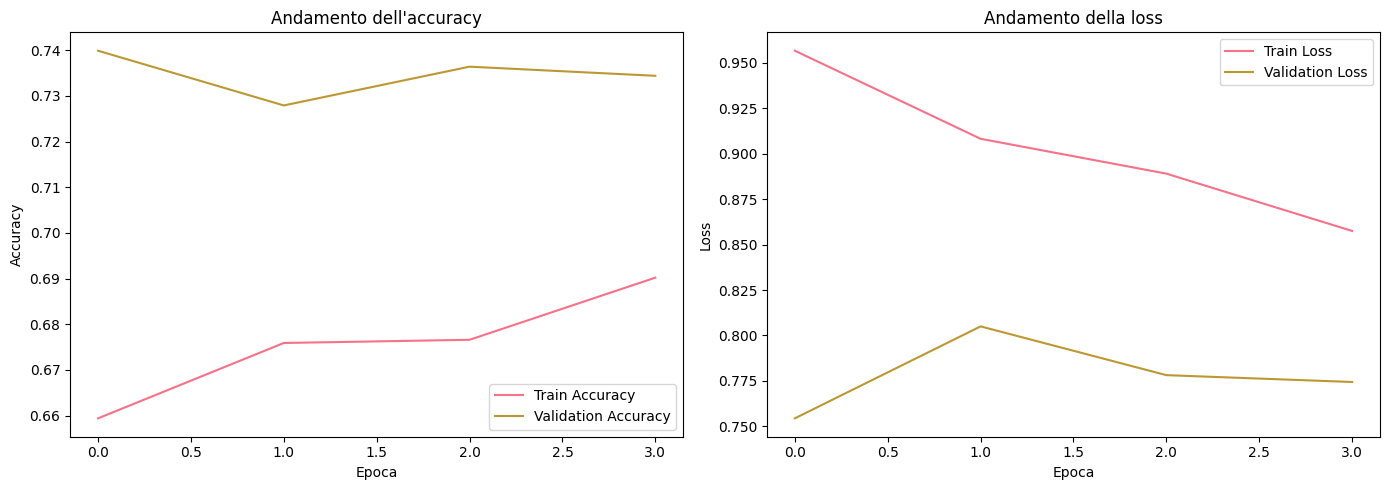

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to saved history
history_path = '/content/drive/MyDrive/history_mobilenetv2.csv'  # ← you have to change it if you used a different name

# Load the history
history_df = pd.read_csv(history_path)

# Plot
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Andamento dell'accuracy")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Andamento della loss")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Training Progress – MobileNetV2

The plot on the left shows the accuracy on the training and validation sets, while the chart on the right displays the loss trend.
- **Training accuracy** increases steadily, reaching around 69% after 3 epochs.
- **Validation accuracy**, on the other hand, remains higher and relatively stable (between 73% and 74%), suggesting that the model is generalizing well from the start thanks to the use of pre-trained weights.

As for the loss:
- **Training loss** consistently decreases, indicating that the model continues to learn.
- **Validation loss** shows slight fluctuations but also tends to decrease, although it starts at a lower value than the training loss.

Overall, the training demonstrates good balance: there are no clear signs of overfitting, and the network seems to gradually adapt to the data without losing generalization ability. However, no significant improvements are observed toward the end of training.


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report
import numpy as np

# 1. Path to the saved model
model_path = '/content/drive/MyDrive/model_mobilenetv2.keras'

# 2. Load the saved model
model = load_model(model_path, compile=False)
print("Modello caricato correttamente.")

# 3. Recompile (required for evaluation/prediction)
model.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# 4. Evaluation on the test set
loss, accuracy = model.evaluate(test_generator, verbose=1)
print(f"\nAccuracy sul test set: {accuracy * 100:.2f}%")
print(f"Loss sul test set: {loss:.4f}")

# 5. Prediction and classification
pred_probs = model.predict(test_generator)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# 6. Full report
print("\nClassification Report:\n")
print(classification_report(true_classes, pred_classes, target_names=class_labels, zero_division=0))


Modello caricato correttamente.
63/63 ━━━━━━━━━━━━━━━━━━━━ 103s 2s/step - accuracy: 0.7297 - loss: 0.7597

Accuracy sul test set: 73.99%
Loss sul test set: 0.7544
63/63 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step

Classification Report:

                      precision    recall  f1-score   support

   Actinic keratosis       0.42      0.35      0.38        65
Basal cell carcinoma       0.42      0.60      0.49       103
    Benign keratosis       0.55      0.32      0.40       220
      Dermatofibroma       0.16      0.39      0.23        23
   Melanocytic nevus       0.85      0.92      0.88      1341
            Melanoma       0.48      0.29      0.36       223
     Vascular lesion       0.58      0.75      0.66        28

            accuracy                           0.74      2003
           macro avg       0.49      0.52      0.49      2003
        weighted avg       0.73      0.74      0.73      2003



### Comparison between Simple CNN and MobileNetV2 Models

Both models were trained on the same balanced dataset, but the results show clear differences.

#### Overall Performance

The model based on MobileNetV2 achieved better results across all major metrics:

- **Test Accuracy:**
  - Simple CNN: 68.0%
  - MobileNetV2: 74.0%

- **Macro-average F1-score**:
  - Simple CNN : 0.36
  - MobileNetV2: 0.49

These values indicate that MobileNetV2 not only achieves higher overall accuracy, but also handles underrepresented classes more effectively, as shown by the significant increase in the macro F1-score.

---

#### Differences by individual class

Here is a direct comparison of the F1‑scores between the two models:

| Classe                | CNN semplice | MobileNetV2 | Differenza |
|----------------------|--------------|-------------|------------|
| Actinic keratosis    | 0.27         | 0.38        | +0.11      |
| Basal cell carcinoma | 0.29         | 0.49        | +0.20      |
| Benign keratosis     | 0.17         | 0.40        | +0.23      |
| Dermatofibroma       | 0.14         | 0.23        | +0.09      |
| Melanocytic nevus    | 0.83         | 0.88        | +0.05      |
| Melanoma             | 0.33         | 0.36        | +0.03      |
| Vascular lesion      | 0.49         | 0.66        | +0.17      |

The improvement is evident across all classes, especially in those where the simple CNN struggled the most.
Classes such as benign keratosis, basal cell carcinoma, and vascular lesion gained over 15 points in F1-score, indicating that MobileNetV2 is better at distinguishing even less frequent or more ambiguous cases.

---

#### Considerations

Given the same data and training conditions, MobileNetV2 clearly performs better.
This advantage likely stems from the pre-trained weights on ImageNet and a more expressive architecture, which is better at capturing complex visual features in dermatological images.

In a context like this, where it is crucial to reliably detect rare or clinically important classes, these differences become critical.


### Binary Classification: Benign vs Malignant

Until now, we have approached the problem as a multiclass classification task, aiming to distinguish between all possible diagnoses present in the dataset.
However, in a clinical context, a more relevant distinction is often between benign (non-threatening) and malignant (potentially dangerous or cancerous) lesions.

In this section, we focus on this aspect: we transform the problem into a **binary classification**, where each image is labeled as either:

- `malignant`:  if it belongs to one of the clinically significant classes,  melanoma, basal cell carcinoma, or actinic keratosis
- `benign`:  in all other cases

---

### Objective
The goal is to train a model capable of reliably distinguishing high-risk lesions from low-risk ones.
This simplification can be very useful in a screening scenario, where the model can help flag the most suspicious cases to be referred for further medical evaluation.

---

### Strategy
- We continue to use MobileNetV2 as the base model, leveraging its pre-trained weights.
- We modify the model’s final output to a single neuron with sigmoid activation, suitable for binary classification.
- The model will be evaluated not only based on accuracy but also on recall for the malignant class, which is particularly important in this context.

### Data Preparation for Binary Classification

In this section, we prepare the data to train a model that distinguishes **between benign and malignant lesions**.


#### 1. Creation of the Binary Label

We start with a dataset containing various dermatological diagnoses. Among them, we have defined three categories as **malignant**:
- `melanoma`
- `basal cell carcinoma` (basal cell carcinoma)
- `actinic keratosis` (actinic keratosis)

All other diagnoses are considered **benign**.

Based on this logic, we create **a new column** called `benigno_maligno`,  which contains the label  `'maligno'` o `'benigno'` for each image:

```python
df['benigno_maligno'] = df['diagnosi'].apply(lambda x: 'maligno' if x.lower() in maligne else 'benigno')


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Binary Classification: Benign vs Malignant

# Definition of diagnoses considered malignant
maligne = ['melanoma', 'basal cell carcinoma', 'actinic keratosis']

# New column: 'benigno_maligno'
df['benigno_maligno'] = df['diagnosi'].apply(lambda x: 'maligno' if x.lower() in maligne else 'benigno')
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    stratify=df['benigno_maligno'],
    random_state=42
)

# Pixel normalization
datagen = ImageDataGenerator(rescale=1./255)

# Parameters
img_size = (224, 224)
batch_size = 32

train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='image_path',
    y_col='benigno_maligno',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='image_path',
    y_col='benigno_maligno',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)


Found 8012 validated image filenames belonging to 2 classes.
Found 2003 validated image filenames belonging to 2 classes.


### Training the Model for Binary Classification

In this phase, we train a new model using the same structure and settings as before (MobileNetV2 with pre-trained weights, Adam optimizer, data augmentation, etc.).

The only difference lies in the **final layer**, which is modified to suit the new **binary classification** task (`benigno` vs `maligno`).  .

Specifically, the output consists of a single neuron with **sigmoid** activation, and the loss function used is **binary cross-entropy**.


In [ ]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import os
import pandas as pd
import matplotlib.pyplot as plt

checkpoint_path = '/content/drive/MyDrive/model_mobilenetv2_binary.keras'
history_path = '/content/drive/MyDrive/history_mobilenetv2_binary.csv'

if os.path.exists(checkpoint_path):
    print("Modello già presente. Caricamento in corso...")
    model = load_model(checkpoint_path)
    trained = True
else:
    print("Creazione nuovo modello MobileNetV2 binario...")

    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    base_model.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=base_model.input, outputs=output)

    model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=['accuracy'])

    checkpoint = ModelCheckpoint(
        filepath=checkpoint_path,
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )

    early_stop = EarlyStopping(
        monitor='val_loss',
        patience=3,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        verbose=1
    )

    # Training
    history = model.fit(
        train_generator,
        epochs=10,
        validation_data=test_generator,
        callbacks=[checkpoint, early_stop, reduce_lr]
    )

    # Save the history
    history_df = pd.DataFrame(history.history)
    history_df.to_csv(history_path, index=False)
    print(f"Cronologia salvata in: {history_path}")
    trained = True


Modello già presente. Caricamento in corso...


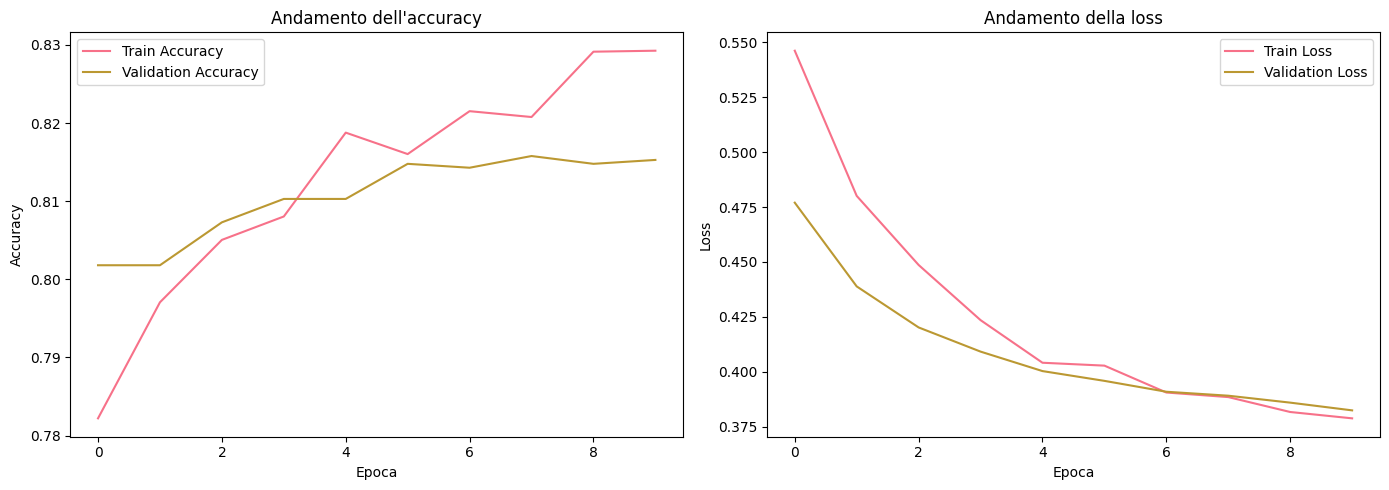

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Path to the saved history
history_path = '/content/drive/MyDrive/history_mobilenetv2_binary.csv'

# Load the history
history_df = pd.read_csv(history_path)

# Plot
plt.figure(figsize=(14, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(history_df['accuracy'], label='Train Accuracy')
plt.plot(history_df['val_accuracy'], label='Validation Accuracy')
plt.title("Andamento dell'accuracy")
plt.xlabel("Epoca")
plt.ylabel("Accuracy")
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history_df['loss'], label='Train Loss')
plt.plot(history_df['val_loss'], label='Validation Loss')
plt.title("Andamento della loss")
plt.xlabel("Epoca")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()


### Training Progress of the Binary Model

The plots show the trends of **accuracy** and **loss** during the training epochs for the binary model (benign vs malignant).

- **Training accuracy** increases steadily, reaching values above 82%.
- **Validation accuracy** remains more stable and slightly lower, around 81%. This is a positive sign: the model generalizes well and does not appear to suffer from overfitting.

On the **loss** plot:
- Both **training** and **validation loss** decrease consistently, indicating that the model is learning effectively.
- The gap between the two curves is minimal, suggesting that performance on the validation set is closely aligned with that on the training set.

In summary, the training process is stable and well-balanced, with no clear signs of overfitting or underfitting. However, it will be important to also evaluate the **final classification metrics** (precision, recall) to better understand how the model performs on the two classes.


Modello binario caricato correttamente.


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


63/63 ━━━━━━━━━━━━━━━━━━━━ 102s 2s/step

Classification Report:

              precision    recall  f1-score   support

     Benigno       0.85      0.93      0.89      1612
     Maligno       0.54      0.34      0.41       391

    accuracy                           0.82      2003
   macro avg       0.70      0.63      0.65      2003
weighted avg       0.79      0.82      0.80      2003



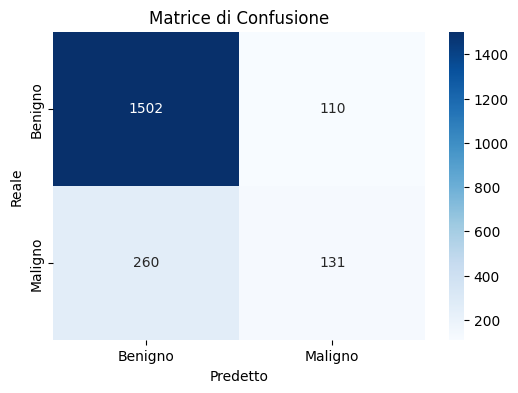

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Path to the saved binary model
model_path = '/content/drive/MyDrive/model_mobilenetv2_binary.keras'

# Model loading
model = load_model(model_path, compile=False)
print("Modello binario caricato correttamente.")

# Recompilation for evaluation (required)
model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Predictions
y_pred_prob = model.predict(test_generator)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# True labels
y_true = test_generator.classes

# Classification Report
target_names = ['Benigno', 'Maligno']
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred, target_names=target_names))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predetto')
plt.ylabel('Reale')
plt.title('Matrice di Confusione')
plt.show()


### Final evaluation of the binary model


The model achieves an overall accuracy of 82%, which appears to be a positive result. However, when examining the classification report, some issues emerge related to the handling of the two classes:

- The **Benign** class, which is much more represented in the dataset, is correctly recognized with strong results: **85% precision** and **93% recall**.

- The **Malignant** class, on the other hand, shows significantly lower performance: **54% precision** and, most notably, a **very low recall (34%)**.

This means that about two out of three malignant lesions are not correctly identified, a serious issue in the medical field, where the priority is to not overlook high-risk cases.

Macro-average metrics:
- **Precision**: 70%
- **Recall**: 63%
- **F1-score**: 65%

These confirm that the model tends to favor the more frequent class (benign), at the expense of sensitivity toward malignant cases.

In conclusion, despite having good overall performance, the model shows a strong imbalance in classification ability between the two classes. Therefore, targeted strategies (e.g., balancing, class weights) will be necessary to increase recall on the malignant class, which is the most critical from a clinical perspective.
